# Import the required libraries

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from catboost import CatBoostClassifier
#import h2o
#from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline 

# Read the datasets

In [44]:
data = pd.read_csv("../train.csv")

data.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [45]:
test = pd.read_csv("../test.csv")

test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
1,213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
2,213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
3,213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
4,213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47


# count of each class

In [46]:
data["label"].value_counts()

correct      15495
incorrect     1681
Name: label, dtype: int64

# Data Cleaning

# Check for duplicated rows, then remove

In [47]:
print (sum(data.duplicated()))

4


In [48]:
data[data.duplicated()]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
4359,194925741,NaN,NaN,NaN,NaN,NaN,11/25/2019 18:13,11/25/2019 18:26,7.29385,80.6366,7.32284,80.6309,790.09,incorrect
4758,195424599,10.5,659.0,50.0,2.8900,241.0,11/27/2019 17:01,11/27/2019 17:12,6.87665,79.9402,6.87854,79.9353,323.75,incorrect
12102,207129558,10.5,599.0,504.0,0.0000,48.0,1/5/2020 13:01,1/5/2020 13:11,6.89164,79.8711,6.87454,79.8595,60.50,incorrect
15352,211508895,10.5,2738.0,1907.0,94.4452,21.0,1/22/2020 18:31,1/22/2020 19:16,7.33268,80.6193,7.29471,80.6369,320.26,incorrect


In [49]:
print(data.shape)

data.drop_duplicates(inplace=True)

print (data.shape)

(17176, 14)
(17172, 14)


Check the data type of each column and do necessary changes

In [50]:
data.dtypes

tripid                         int64
additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
pickup_time                   object
drop_time                     object
pick_lat                     float64
pick_lon                     float64
drop_lat                     float64
drop_lon                     float64
fare                         float64
label                         object
dtype: object

In [51]:
data["pickup_time"] = pd.to_datetime(data["pickup_time"])
data["drop_time"] = pd.to_datetime(data["drop_time"])
data["label"] = data["label"].apply(lambda x: 1 if x=="correct" else 0)

test["pickup_time"] = pd.to_datetime(test["pickup_time"])
test["drop_time"] = pd.to_datetime(test["drop_time"])

# Null Value handling

In [52]:
data[data["label"]==1].isna().describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
count,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495
unique,1,2,2,2,2,2,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,15495,15442,15442,15442,15442,15442,15495,15495,15495,15495,15495,15495,15495,15495


In [53]:
data[data["label"]==0].isna().describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
count,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677,1677
unique,1,2,2,2,2,2,1,1,1,1,1,1,2,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,1677,1529,1529,1529,1529,1529,1677,1677,1677,1677,1677,1677,1540,1677


In [54]:
test.isna().describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
count,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576
unique,1,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576


Fill the Cells with NaN with the mean value of that column

In [55]:
data["additional_fare"].fillna(data["additional_fare"].mean() , inplace=True)
data["duration"].fillna(data["duration"].mean() , inplace=True)
data["meter_waiting"].fillna(data["meter_waiting"].mean() , inplace=True)
data["meter_waiting_fare"].fillna(data["meter_waiting_fare"].mean() , inplace=True)
data["meter_waiting_till_pickup"].fillna(data["meter_waiting_till_pickup"].mean() , inplace=True)
data["fare"].fillna(data["fare"].mean() , inplace=True)

# EDA

Let's Explore the distribution of each featue

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3794a18b38>,
      dtype=object)

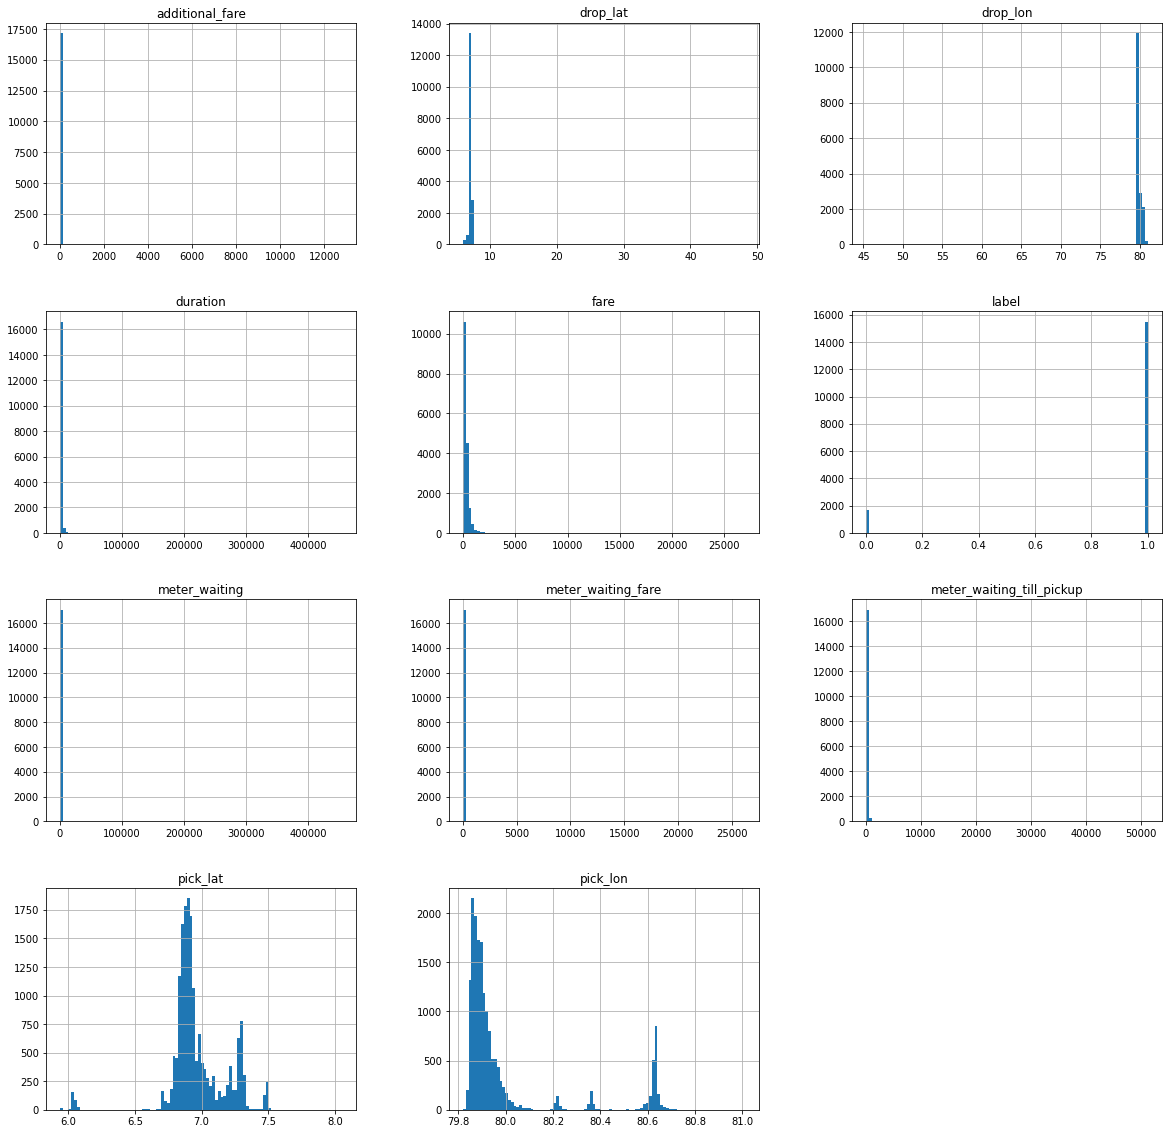

In [56]:
data.iloc[:,1:].hist(figsize=(20,20) , bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3791672a20>,
      dtype=object)

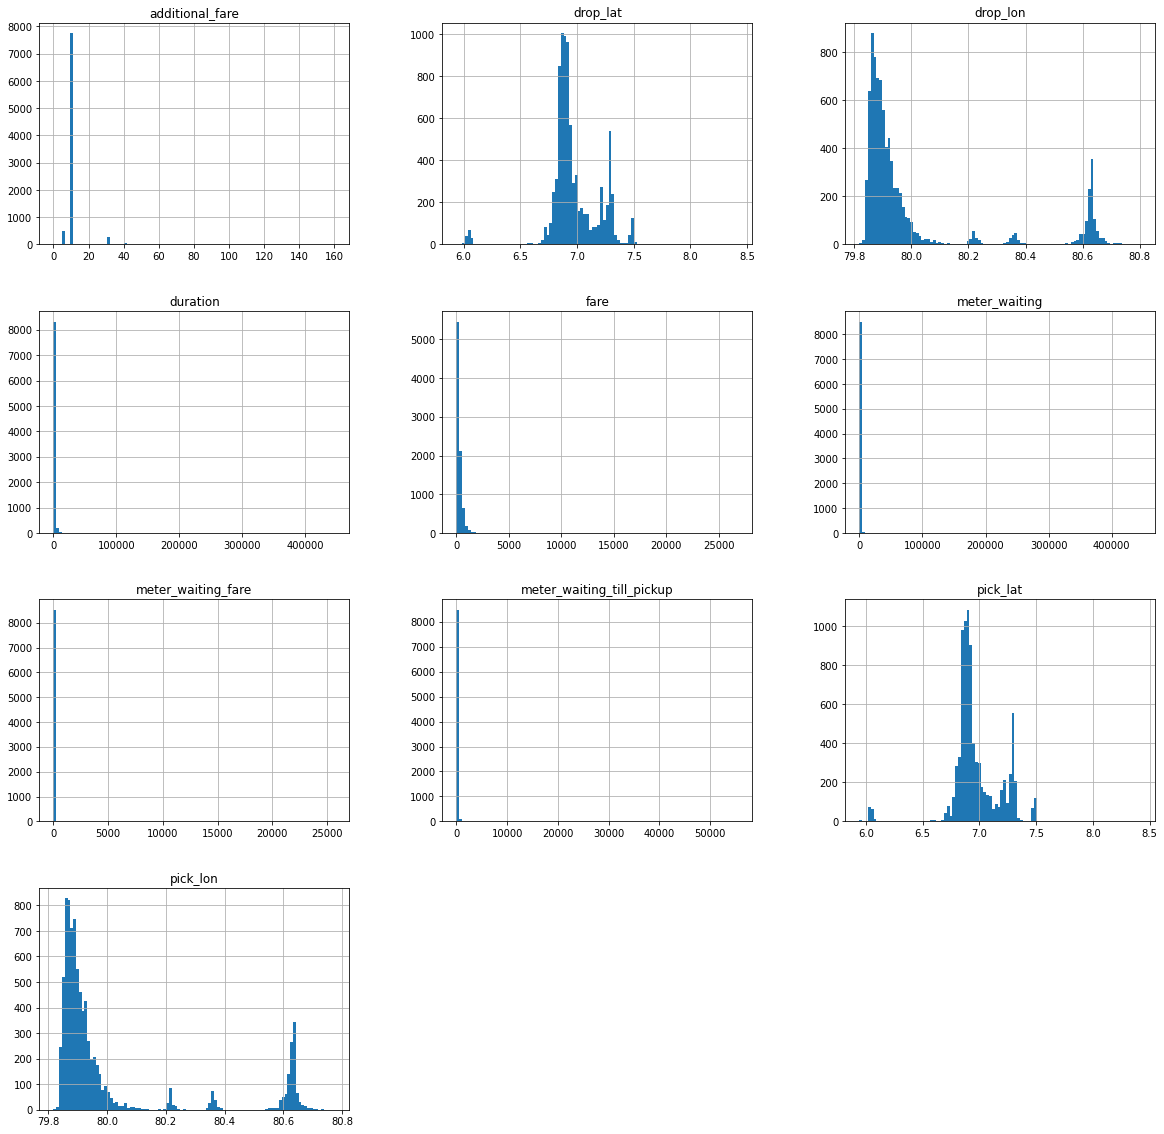

In [57]:
test.iloc[:,1:].hist(figsize=(20,20) , bins=100)

In [58]:
data.corr()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,1.000000,0.019031,-0.019637,-0.016794,-0.017206,-0.017718,0.027303,0.027044,0.005493,0.028393,-0.014469,0.062639
additional_fare,0.019031,1.000000,-0.000773,0.197605,0.199605,0.002355,0.009076,0.000620,0.004636,0.001536,0.315191,-0.039279
duration,-0.019637,-0.000773,1.000000,0.969788,0.968666,0.040581,-0.026949,-0.025416,-0.015949,-0.013575,0.864994,-0.108428
meter_waiting,-0.016794,0.197605,0.969788,1.000000,0.999474,0.030450,-0.016100,-0.014124,-0.010107,-0.007895,0.869866,-0.102931
meter_waiting_fare,-0.017206,0.199605,0.968666,0.999474,1.000000,0.029911,-0.014948,-0.012407,-0.009421,-0.006797,0.864813,-0.099155
meter_waiting_till_pickup,-0.017718,0.002355,0.040581,0.030450,0.029911,1.000000,0.011356,0.016409,0.006948,0.011047,0.045451,-0.033908
pick_lat,0.027303,0.009076,-0.026949,-0.016100,-0.014948,0.011356,1.000000,0.522256,0.560405,0.339930,-0.024581,-0.028826
pick_lon,0.027044,0.000620,-0.025416,-0.014124,-0.012407,0.016409,0.522256,1.000000,0.307169,0.654754,-0.035236,-0.036987
drop_lat,0.005493,0.004636,-0.015949,-0.010107,-0.009421,0.006948,0.560405,0.307169,1.000000,-0.414858,-0.015567,-0.012563
drop_lon,0.028393,0.001536,-0.013575,-0.007895,-0.006797,0.011047,0.339930,0.654754,-0.414858,1.000000,-0.014978,-0.029857


# Remove outliers

Let's Plot boxplot to see there any outliers

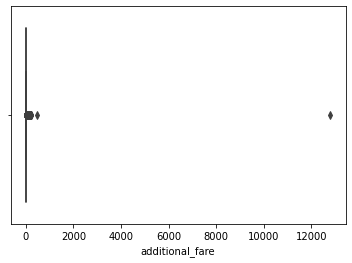

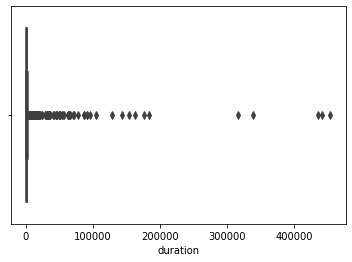

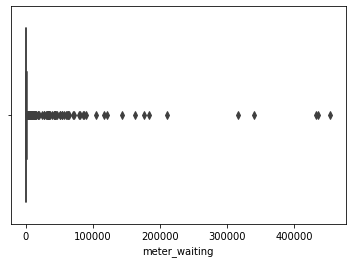

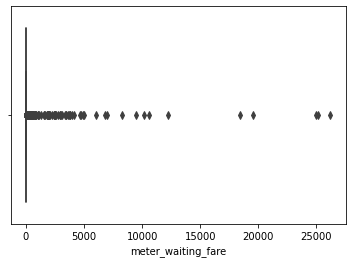

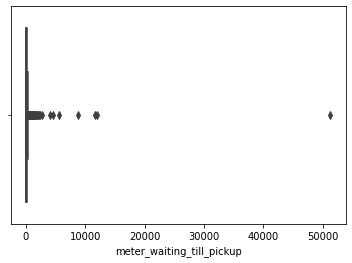

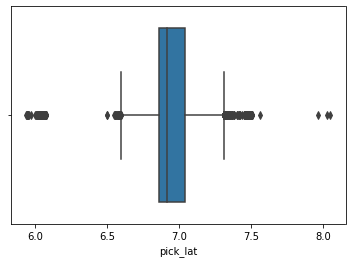

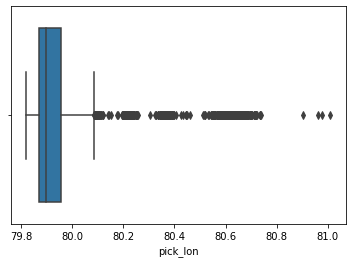

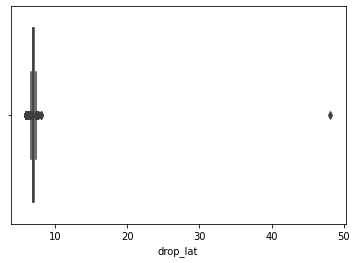

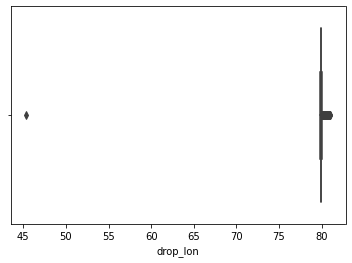

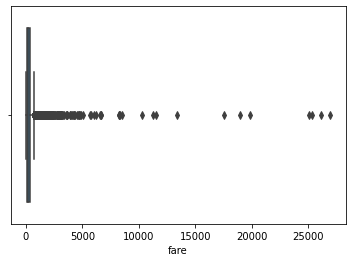

In [59]:
column_names = list(data.columns)
column_names.remove("pickup_time")
column_names.remove("drop_time")
column_names.remove("tripid")
column_names.remove("label")
for i in column_names:
    sn.boxplot(data[i])
    plt.show()

In [60]:
Q1 = data.drop(["pickup_time","drop_time","tripid","label"] , axis=1).quantile(0.05)
Q3 = data.drop(["pickup_time","drop_time","tripid","label"] , axis=1).quantile(0.95)
IQR = Q3 - Q1
print(IQR)

additional_fare                25.500000
duration                     3694.450000
meter_waiting                1273.000000
meter_waiting_fare             71.224450
meter_waiting_till_pickup     328.000000
pick_lat                        0.518163
pick_lon                        0.784045
drop_lat                        0.528232
drop_lon                        0.782900
fare                          730.096000
dtype: float64


In [61]:
print((data.drop(["pickup_time","drop_time","tripid","label"] , axis=1) < (Q1 - 1.5 * IQR)) |(data.drop(["pickup_time","drop_time","tripid","label"] , axis=1) > (Q3 + 1.5 * IQR)))

       additional_fare  duration  meter_waiting  meter_waiting_fare  \
0                False     False          False               False   
1                False     False          False               False   
2                False     False          False               False   
3                False     False          False               False   
4                False     False          False               False   
...                ...       ...            ...                 ...   
17171            False     False          False               False   
17172            False     False          False               False   
17173            False     False          False               False   
17174            False     False          False               False   
17175            False     False          False               False   

       meter_waiting_till_pickup  pick_lat  pick_lon  drop_lat  drop_lon  \
0                          False     False     False     False     Fals

In [62]:
data = data[~((data.drop(["pickup_time","drop_time","tripid","label"] , axis=1) < (Q1 - 1.5 * IQR)) |(data.drop(["pickup_time","drop_time","tripid","label"] , axis=1) > (Q3 + 1.5 * IQR))).any(axis=1)]

In [63]:
data.shape

(16672, 14)

# Feature Engineering

Create new features from the existing features
    pickup_time_minuts - number of minutes past from 12 AM 
    Distance - Euclidean distance using longitude and latitude

In [64]:
data["pickup_time_minuts"] = data["pickup_time"].apply(lambda x: int(x.strftime("%M"))+int(x.strftime("%H"))*60)
data["distance"] = ((data["pick_lat"]-data["drop_lat"])**2 + (data["pick_lon"] - data["drop_lon"])**2 )**0.5

#data["drop_time_minuts"] = data["drop_time"].apply(lambda x: int(x.strftime("%M"))+int(x.strftime("%H"))*60)
#data["pickup_day"] = data["pickup_time"].apply(lambda x: int(x.strftime("%w")))
#data["drop_day"] = data["drop_time"].apply(lambda x: int(x.strftime("%w")))
#data["pickup_month"] = data["pickup_time"].apply(lambda x: int(x.strftime("%m")))
#data["drop_month"] = data["drop_time"].apply(lambda x: int(x.strftime("%m")))



test["pickup_time_minuts"] = test["pickup_time"].apply(lambda x: int(x.strftime("%M"))+int(x.strftime("%H"))*60)
test["distance"] = ((test["pick_lat"]-test["drop_lat"])**2 + (test["pick_lon"] - test["drop_lon"])**2 )**0.5

#test["drop_time_minuts"] = test["drop_time"].apply(lambda x: int(x.strftime("%M"))+int(x.strftime("%H"))*60)
#test["pickup_day"] = test["pickup_time"].apply(lambda x: int(x.strftime("%w")))
#test["drop_day"] = test["drop_time"].apply(lambda x: int(x.strftime("%w")))
#test["pickup_month"] = test["pickup_time"].apply(lambda x: int(x.strftime("%m")))
#test["drop_month"] = test["drop_time"].apply(lambda x: int(x.strftime("%m")))


    date_diff - difference of drop and pickup time in seconds

In [65]:
data["date_diff"] = data['drop_time'] - data['pickup_time']
data['date_diff']=data['date_diff']/np.timedelta64(1,'s')

test["date_diff"] = test['drop_time'] - test['pickup_time']
test['date_diff']=test['date_diff']/np.timedelta64(1,'s')

In [66]:
data["tot_time"] = data["meter_waiting_till_pickup"] + data["meter_waiting"]
test["tot_time"] = test["meter_waiting_till_pickup"] + test["meter_waiting"]
data["tot_fare"] = data["additional_fare"] + data["meter_waiting_fare"] + data["fare"]
test["tot_fare"] = test["additional_fare"] + test["meter_waiting_fare"] + test["fare"]


In [67]:
data.drop(["tripid" , "pickup_time" , "drop_time" ], axis=1, inplace=True)

test.drop(["tripid" , "pickup_time" , "drop_time" ], axis=1, inplace=True)

# Get the featue importance

Feature ranking:
1. duration 1 (0.163033)
2. distance 12 (0.123182)
3. pickup_time_minuts 11 (0.116246)
4. fare 9 (0.105685)
5. tot_time 14 (0.104374)
6. meter_waiting 2 (0.056100)
7. date_diff 13 (0.049156)
8. meter_waiting_till_pickup 4 (0.040078)
9. label 10 (0.038111)
10. meter_waiting_fare 3 (0.038102)
11. drop_lon 8 (0.037159)
12. pick_lat 5 (0.037084)
13. drop_lat 7 (0.036219)
14. pick_lon 6 (0.036039)
15. additional_fare 0 (0.019430)


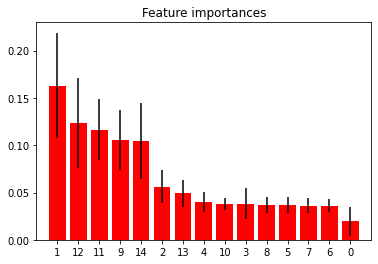

In [68]:
tree_cls = RandomForestClassifier()

tree_cls.fit(data.drop(["label"],axis=1),data["label"])

importances = tree_cls.feature_importances_
std = np.std([tree.feature_importances_ for tree in tree_cls.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]-1):
    print("%d. %s %d (%f)" % (f + 1,data.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data.shape[1]-1), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]-1), indices)
plt.xlim([-1, data.shape[1]-1])
plt.show()

In [69]:
data.drop([ "drop_lon" , "drop_lat" , "pick_lon" , "pick_lat" ], axis=1, inplace=True)

test.drop([ "drop_lon" , "drop_lat" , "pick_lon" , "pick_lat"], axis=1, inplace=True)


In [70]:
data.drop(["meter_waiting_till_pickup" , "meter_waiting"], axis=1, inplace=True)

test.drop(["meter_waiting_till_pickup" , "meter_waiting"], axis=1, inplace=True)

data.drop(["meter_waiting_fare" , "additional_fare"], axis=1, inplace=True)

test.drop(["meter_waiting_fare" , "additional_fare"], axis=1, inplace=True)


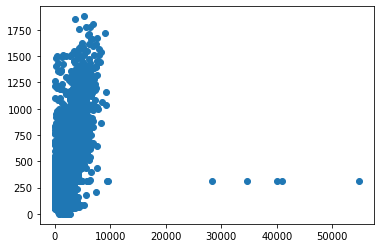

In [71]:
plt.scatter(data["date_diff"] , data["fare"])

# Splitting the dataset

In [72]:
X = data.drop(["label"],axis=1)
scale = MinMaxScaler()

X = scale.fit_transform(X)

Y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

print (y_train.value_counts())
print(y_test.value_counts())


1    12179
0     1158
Name: label, dtype: int64
1    3028
0     307
Name: label, dtype: int64


# Training and Prediction

# XGBoost Classifier

In [73]:
xg_clf = xgboost.XGBClassifier(n_estimators = 1000)

cv = cross_validate(xg_clf, X,Y,cv=4, scoring= {'f1' , 'accuracy' , 'recall' , 'precision'}, return_train_score=True)

print (cv['train_accuracy'])
print ("Mean Accuracy(Training) : " , cv['train_accuracy'].mean())

print (cv['train_recall'])
print ("Mean Recall Score(Training) : " ,cv['train_recall'].mean())

print (cv['train_precision'])
print ("Mean Precision Score(Training) : " ,cv['train_precision'].mean())

print (cv['train_f1'])
print ("Mean F1 Score(Training) : " ,cv['train_f1'].mean())

print (cv['test_accuracy'])
print ("Mean Accuracy Score(Testing) : " ,cv['test_accuracy'].mean())

print (cv['test_recall'])
print ("Mean recall Score(Testing) : " ,cv['test_recall'].mean())

print (cv['test_precision'])
print ("Mean Precision Score(Testing) : " , cv['test_precision'].mean())

print (cv['test_f1'])
print ("Mean F1 Score(Testing) : " ,cv['test_f1'].mean())

[0.9796865  0.97832694 0.98016635 0.98072617]
Mean Accuracy(Training) :  0.9797264875239924
[0.99833406 0.99833406 0.99824638 0.99886025]
Mean Recall Score(Training) :  0.9984436900427666
[0.97977799 0.97834679 0.98036683 0.98038035]
Mean Precision Score(Training) :  0.9797179898271989
[0.98896899 0.98823938 0.98922582 0.98953403]
Mean F1 Score(Training) :  0.9889920546678261
[0.95297505 0.95705374 0.95585413 0.94817658]
Mean Accuracy Score(Testing) :  0.9535148752399233
[0.98474487 0.99289847 0.99263546 0.98973954]
Mean recall Score(Testing) :  0.9900045857142443
[0.96445131 0.96129361 0.96030534 0.95506474]
Mean Precision Score(Testing) :  0.9602787507156583
[0.97449245 0.97684047 0.97620279 0.97209302]
Mean F1 Score(Testing) :  0.9749071849106156


In [16]:
clf = xgboost.XGBClassifier(n_estimators = 1000)

clf.fit(X_train,y_train)

pred = clf.predict(X_test)

print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

[[ 198  114]
 [  37 3087]]
0.9761264822134387
[[ 1076   293]
 [   31 12340]]
0.9870420732682771


t_pred = clf.predict(scale.transform(test))

test_sub = pd.read_csv("../sample_submission.csv")

test_sub["prediction"] = t_pred

test_sub.to_csv("../xg_0614_null_values_filled_with_mean_three_extra.csv" , index=False)

# Random Forest Classifier

In [74]:
rf1_clf = RandomForestClassifier(n_estimators=1000 )

cv = cross_validate(rf1_clf, X,Y,cv=4, scoring= {'f1' , 'accuracy' , 'recall' , 'precision'}, return_train_score = True)

print (cv['train_accuracy'])
print ("Mean Accuracy(Training) : " , cv['train_accuracy'].mean())

print (cv['train_recall'])
print ("Mean Recall Score(Training) : " ,cv['train_recall'].mean())

print (cv['train_precision'])
print ("Mean Precision Score(Training) : " ,cv['train_precision'].mean())

print (cv['train_f1'])
print ("Mean F1 Score(Training) : " ,cv['train_f1'].mean())

print (cv['test_accuracy'])
print ("Mean Accuracy Score(Testing) : " ,cv['test_accuracy'].mean())

print (cv['test_recall'])
print ("Mean recall Score(Testing) : " ,cv['test_recall'].mean())

print (cv['test_precision'])
print ("Mean Precision Score(Testing) : " , cv['test_precision'].mean())

print (cv['test_f1'])
print ("Mean F1 Score(Testing) : " ,cv['test_f1'].mean())

[1. 1. 1. 1.]
Mean Accuracy(Training) :  1.0
[1. 1. 1. 1.]
Mean Recall Score(Training) :  1.0
[1. 1. 1. 1.]
Mean Precision Score(Training) :  1.0
[1. 1. 1. 1.]
Mean F1 Score(Training) :  1.0
[0.95537428 0.95705374 0.95897313 0.94841651]
Mean Accuracy Score(Testing) :  0.9549544145873321
[0.98605997 0.99395055 0.99289847 0.98921336]
Mean recall Score(Testing) :  0.9905305900424056
[0.96573931 0.96035578 0.96325593 0.95577021]
Mean Precision Score(Testing) :  0.961280308039468
[0.97579386 0.97686442 0.97785261 0.97220427]
Mean F1 Score(Testing) :  0.9756787877966037


In [77]:
rf_clf = RandomForestClassifier(n_estimators=1000)

rf_clf.fit(X,Y)

pred = rf_clf.predict(X_test)

print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = rf_clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

[[ 307    0]
 [   0 3028]]
1.0
[[ 1158     0]
 [    0 12179]]
1.0


In [78]:
t_pred = rf_clf.predict(scale.transform(test))

test_sub = pd.read_csv("../sample_submission.csv")

test_sub["prediction"] = t_pred

test_sub.to_csv("../rf_0614_null_values_filled_with_mean_added_distance_totfare_tottime_feature_rem_outliers.csv" , index=False)

Manually checking the misclassified data samples

In [ ]:
pred_cv = rf_clf.predict(X)

data["pred"] = pred_cv

data1 = data[data["pred"]!= data["label"] ]

data1


In [ ]:
data1["label"].value_counts()

In [ ]:
data1.describe()

# Gradient Boosting Classifier

In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=1000 , max_depth=8, min_samples_split=2)

gb_clf.fit(X_train,y_train)

pred = gb_clf.predict(X_test)


print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = gb_clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

# Logistic Regression Classifier

In [ ]:
lr_clf = LogisticRegression()

lr_clf.fit(X_train,y_train)

pred = lr_clf.predict(X_test)

print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = lr_clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

# Naive Bayes Classifier with Gaussian 

In [ ]:
gnb_clf = GaussianNB()

gnb_clf.fit(X_train,y_train)

pred = gnb_clf.predict(X_test)

print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred = gnb_clf.predict(X_train)

print (confusion_matrix(y_train,pred))

print (f1_score(y_train,pred))


# Classification with multi layer perseptron ( Neural Networks )

In [ ]:
mlp_clf = MLPClassifier(activation='relu', solver='sgd' , verbose=True , early_stopping=False , tol= 10**-20)

mlp_clf.fit(X_train,y_train)

pred = mlp_clf.predict(X_test)


print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = mlp_clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

# Cat boost classifier

In [ ]:
cat_clas = CatBoostClassifier(loss_function = 'Logloss')
#iterations=9000, depth=8, learning_rate=0.01, loss_function='Logloss')
#cat_clas.fit(X_train, y_train)

param_grid = {'learning_rate': [0.03, 0.1 , 0.01 ],
            'depth': [4, 6, 10 , 15],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'iterations' : [5000, 9000 , 13000 , 17000]}

grid_search_result = cat_clas.grid_search(param_grid,
            X_train,
            y_train,
            cv=4,
            partition_random_seed=0,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=True,
            train_size=0.8,
            verbose=True,
            plot=True)

In [ ]:
pred = cat_clas.predict(X_test)


print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = cat_clas.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

In [ ]:
h2o.init()

gbm_classifier = H2OGradientBoostingEstimator(distribution="multinomial", ntrees=10, max_depth=3, min_rows=2, learn_rate=0.2)

gbm_classifier.train(x=X_train , y=y_train)